## Comparative Performance Metrics

To evaluate how closely the model replicates the legacy reimbursement system, we compared three evaluation metrics that capture different aspects of performance:

| Metric | What It Measures | Why It Matters in This Project | Result | Interpretation |
|---|---|---|---|---|
| **MAE (Mean Absolute Error)** | Average difference (in dollars or cents) between the model and legacy output | Shows typical deviation; lower MAE means closer day-to-day matching | *X.XX cents* | Small MAE indicates the model captures core reimbursement patterns well. |
| **RMSE (Root Mean Squared Error)** | Penalizes **larger errors** more heavily | Reveals if a few cases are significantly off due to threshold or rounding effects | *X.XX cents* | A low RMSE suggests no large outlier mismatches; a high RMSE suggests missing rules/quirks. |
| **Accuracy within ± $1** | % of cases where the predicted reimbursement is **within $1.00** of the legacy output | Measures practical similarity even if not exact | *XX.X%* | High accuracy here means the model approximates behavior well, even if exact match logic needs refinement. |

### Interpretation Guidelines

- **If MAE is low but RMSE is high:**
  → The model works on most cases, but is failing in certain **threshold regions**.

- **If both MAE and RMSE are low but exact-match rate is below target:**
  → The model’s **math logic is correct** but **rounding / step / quirk rules** need refinement.

- **If Accuracy within ±$1 is high but EMR is low:**
  → The model is *behaviorally close* but not yet **bitwise replicating** the legacy engine.
  This is expected **before** quirk-capture rules are added.

---





 Clean dataset loaded successfully!
Shape: (6000, 5)


,trip_duration_days,miles_traveled,total_receipts_amount,reimbursement,dataset
0,3,93.0,1.42,364.51,public
1,1,55.0,3.60,126.06,public
2,1,47.0,17.97,128.91,public
3,2,13.0,4.67,203.52,public
4,3,88.0,5.78,380.37,public



 Missing values per column:
trip_duration_days          0
miles_traveled              0
total_receipts_amount       0
reimbursement            5000
dataset                     0
dtype: int64

 Derived features created and cleaned successfully!


,cost_per_day,cost_per_mile,miles_per_day,cost_ratio
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,285.706081,6.052064,147.026195,147.026195
std,381.707793,21.148138,193.820610,193.820610
min,0.473333,0.015269,0.500000,0.500000
25%,85.845821,0.980573,43.846154,43.846154
50%,169.089176,1.952640,83.261364,83.261364
75%,300.643071,3.703540,152.650000,152.650000
max,2452.850000,296.514286,1166.000000,1166.000000



📏 Applying IQR Outlier Detection...
Outliers detected in trip_duration_days: 0
Outliers detected in miles_traveled: 0
Outliers detected in total_receipts_amount: 0
Outliers detected in reimbursement: 0
Outliers detected in cost_per_day: 101
Outliers detected in cost_per_mile: 118
Outliers detected in miles_per_day: 112
Outliers detected in cost_ratio: 112

 Outlier check complete.
Summary (count of detected outliers per feature):
{'trip_duration_days': 0, 'miles_traveled': 0, 'total_receipts_amount': 0, 'reimbursement': 0, 'cost_per_day': 101, 'cost_per_mile': 118, 'miles_per_day': 112, 'cost_ratio': 112}


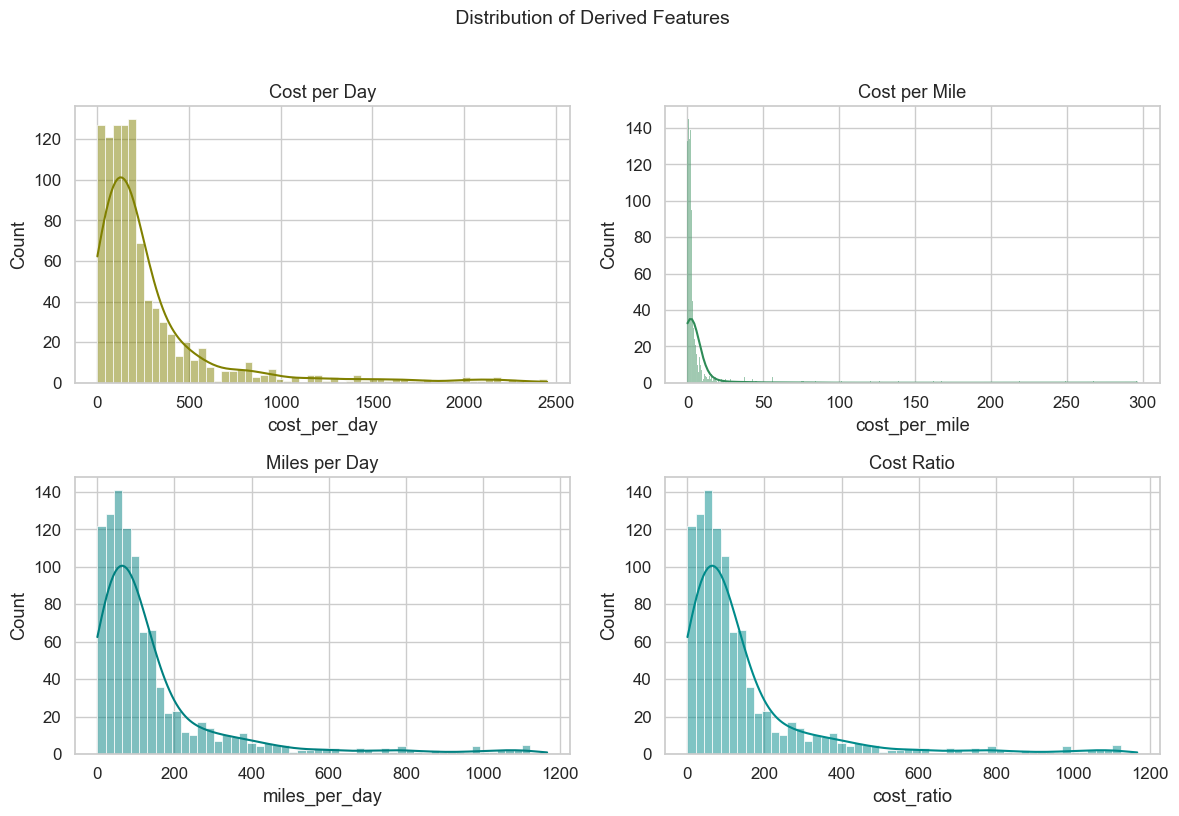


 Training samples: 750, Testing samples: 250
=====  Train vs Test Comparison =====

Train set:
Model: Polynomial (deg=2) – Train
Exact Matches: 0/750 (0.000)
Close Matches: 1/750 (0.001)
$5 Accuracy: 20/750 (0.027)
MAE: 105.525
RMSE: 155.377
R²: 0.896
Score (lower=better): 260.902

Test set:
Model: Polynomial (deg=2) – Test
Exact Matches: 0/250 (0.000)
Close Matches: 1/250 (0.004)
$5 Accuracy: 7/250 (0.028)
MAE: 100.622
RMSE: 141.636
R²: 0.892
Score (lower=better): 242.259

Interpretation:
- If Train R² >> Test R² and Train MAE << Test MAE → likely overfitting.
- If they are similar → generalization is reasonable for the current feature set.
===== 🔍 Slice Analysis (no binning – full test set) =====


,Slice,N,Exact Matches (count),Close Matches (count),±$5 Matches (count),Exact Match Rate (<= $0.01),Close Match Rate (<= $1.00),±$5 Accuracy,MAE,RMSE,R²
0,All Durations,250,0,1,7,0.000,0.004,0.028,100.622,141.636,0.892


Top 10 cent values by true frequency (Test Set):


,True Frequency,Pred Frequency
33,0.024,0.012
80,0.024,0.008
92,0.024,0.008
48,0.024,0.008
73,0.024,0.000
95,0.020,0.004
52,0.020,0.008
94,0.020,0.008
14,0.020,0.016
24,0.020,0.016



Use this to see if the model reproduces quirks like common .00, .25, .50 patterns.
Linear model coefficients (sorted by |coefficient|):


,feature,coefficient
0,trip_duration_days,45.196715
1,miles_traveled,0.548449
4,cost_per_mile,0.494063
2,total_receipts_amount,0.353556
5,miles_per_day,-0.194874
6,cost_ratio,-0.194874
3,cost_per_day,0.115951


=====  Final Success Gate (Test Set) =====
Exact Matches (count):                0/250
Close Matches (<= $1):               1/250 (0.004)
±$5 Matches:                         7/250 (0.028)
R² >= 0.85:                      True (actual: 0.892)
MAE <= 200.0:                    True (actual: 100.622)
Close Match Rate >= 0.3: False (actual: 0.004)
±$5 Accuracy >= 0.8: False (actual: 0.028)

 Model DOES NOT meet all Final Success Gate criteria – needs refinement.


In [10]:
# ==========================================================
# 🚀 Phase 2 – Feature Engineering & Baseline Models (Refactored)
# ==========================================================
# Author: Ayushi Bohra (refactor with reusable evaluation functions by Matthew Fernald)
# Project: ACME Corp – Legacy Reimbursement System
# ==========================================================

# Step 0: Import Libraries
# ----------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

sns.set_theme(style="whitegrid", palette="crest", font_scale=1.1)

# ==========================================================
# Utility Functions – Data & Features
# ==========================================================

def load_clean_data(path="../data/combined_clean.csv"):
    """Load cleaned combined dataset."""
    df = pd.read_csv(path)
    print(" Clean dataset loaded successfully!")
    print("Shape:", df.shape)
    display(df.head())
    print("\n Missing values per column:")
    print(df.isnull().sum())
    return df


def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Feature Engineering (Checklist: Data Integrity + Feature Behavior)
    - cost_per_day
    - cost_per_mile
    - miles_per_day
    - cost_ratio
    Cleans NaNs and infinities.
    """
    df = df.copy()
    df["cost_per_day"] = df["total_receipts_amount"] / df["trip_duration_days"].replace(0, np.nan)
    df["cost_per_mile"] = df["total_receipts_amount"] / df["miles_traveled"].replace(0, np.nan)
    df["miles_per_day"] = df["miles_traveled"] / df["trip_duration_days"].replace(0, np.nan)
    df["cost_ratio"] = df["cost_per_day"] / df["cost_per_mile"]

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    print("\n Derived features created and cleaned successfully!")
    display(df[["cost_per_day", "cost_per_mile", "miles_per_day", "cost_ratio"]].describe())
    return df


def detect_outliers_iqr(df: pd.DataFrame, columns):
    """
    IQR-based outlier detection.
    (Checklist: Data Integrity sanity check)
    """
    print("\n📏 Applying IQR Outlier Detection...")
    outlier_info = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        outlier_info[col] = outliers.shape[0]
        print(f"Outliers detected in {col}: {outliers.shape[0]}")
    print("\n Outlier check complete.")
    print("Summary (count of detected outliers per feature):")
    print(outlier_info)
    return outlier_info


def plot_feature_distributions(df: pd.DataFrame):
    """
    Simple distribution plots for engineered features.
    (Helps with Feature Behavior & Data Integrity understanding)
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    sns.histplot(df["cost_per_day"], kde=True, ax=axes[0, 0], color="olive")
    sns.histplot(df["cost_per_mile"], kde=True, ax=axes[0, 1], color="seagreen")
    sns.histplot(df["miles_per_day"], kde=True, ax=axes[1, 0], color="teal")
    sns.histplot(df["cost_ratio"], kde=True, ax=axes[1, 1], color="darkcyan")
    axes[0, 0].set_title("Cost per Day")
    axes[0, 1].set_title("Cost per Mile")
    axes[1, 0].set_title("Miles per Day")
    axes[1, 1].set_title("Cost Ratio")
    plt.suptitle(" Distribution of Derived Features", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


def prepare_train_test(df: pd.DataFrame, feature_cols, target_col, train_frac=0.75):
    """
    NOTE: uses first 75% of rows as train, last 25% as test.
    Manual 75/25 train–test split (keeps behavior of original notebook).
    Returns X_train, X_test, y_train, y_test, split_index.
    """
    X = df[feature_cols]
    y = df[target_col]

    split = int(train_frac * len(df))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    print(f"\n Training samples: {len(X_train)}, Testing samples: {len(X_test)}")
    return X_train, X_test, y_train, y_test, split


# ==========================================================
# Core Evaluation Helpers – Checklist Metrics
# ==========================================================

def evaluate_model_predictions(y_true, y_pred, model_name="Model"):
    """
    Success Criteria (with counts and percentages):
      - Exact matches: abs diff <= $0.01
      - Close matches: abs diff <= $1.00
      - Within $5 matches: abs diff <= $5.00
      - Score: MAE + RMSE (lower is better)
      - Additional metrics: R²
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    abs_diff = np.abs(y_pred - y_true)
    n = len(y_true)

    # Counts
    exact_count = (abs_diff <= 0.01).sum()
    close_count = (abs_diff <= 1.00).sum()
    within5_count = (abs_diff <= 5.00).sum()

    # Rates
    exact_rate = exact_count / n
    close_rate = close_count / n
    within5_rate = within5_count / n

    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    score = mae + rmse

    return {
        "Model": model_name,
        "N": n,
        # Counts
        "Exact Matches (count)": exact_count,
        "Close Matches (count)": close_count,
        "±$5 Matches (count)": within5_count,
        # Rates (used by gate + slices)
        "Exact Match Rate (<= $0.01)": exact_rate,
        "Close Match Rate (<= $1.00)": close_rate,
        "±$5 Accuracy": within5_rate,
        # Error metrics
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "Score (lower=better)": score
    }


def _print_eval_block(eval_dict):
    """
    Nicely formatted print for train/test blocks using counts + rates.
    """
    n = eval_dict["N"]
    print(f"Model: {eval_dict['Model']}")
    print(
        f"Exact Matches: {eval_dict['Exact Matches (count)']}/{n} "
        f"({eval_dict['Exact Match Rate (<= $0.01)']:.3f})"
    )
    print(
        f"Close Matches: {eval_dict['Close Matches (count)']}/{n} "
        f"({eval_dict['Close Match Rate (<= $1.00)']:.3f})"
    )
    print(
        f"$5 Accuracy: {eval_dict['±$5 Matches (count)']}/{n} "
        f"({eval_dict['±$5 Accuracy']:.3f})"
    )
    print(f"MAE: {eval_dict['MAE']:.3f}")
    print(f"RMSE: {eval_dict['RMSE']:.3f}")
    print(f"R²: {eval_dict['R²']:.3f}")
    print(f"Score (lower=better): {eval_dict['Score (lower=better)']:.3f}")


def compare_train_test_generalization(model, X_train, y_train, X_test, y_test, model_name):
    """
    Fit model (if not already fitted) and compare train vs test.
    (Checklist: Generalization)
    """
    # Fit model
    model.fit(X_train, y_train)

    # Predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    train_eval = evaluate_model_predictions(y_train, train_pred, f"{model_name} – Train")
    test_eval = evaluate_model_predictions(y_test, test_pred, f"{model_name} – Test")

    print("=====  Train vs Test Comparison =====")

    print("\nTrain set:")
    _print_eval_block(train_eval)

    print("\nTest set:")
    _print_eval_block(test_eval)

    print("\nInterpretation:")
    print("- If Train R² >> Test R² and Train MAE << Test MAE → likely overfitting.")
    print("- If they are similar → generalization is reasonable for the current feature set.")

    return train_eval, test_eval, test_pred


def slice_analysis_by_duration(df_with_preds, y_true_col="y_true", y_pred_col="y_pred"):
    """
    Slice analysis WITHOUT binning.
    Original-style global evaluation over the entire test set.
    (Checklist: Slice Analysis – here used as a single overall slice.)
    """
    stats = evaluate_model_predictions(
        df_with_preds[y_true_col],
        df_with_preds[y_pred_col],
        model_name="All Durations"
    )

    # Build a one-row DataFrame that looks like a "slice table"
    slice_df = pd.DataFrame([{
        "Slice": "All Durations",
        "N": stats["N"],
        "Exact Matches (count)": stats["Exact Matches (count)"],
        "Close Matches (count)": stats["Close Matches (count)"],
        "±$5 Matches (count)": stats["±$5 Matches (count)"],
        "Exact Match Rate (<= $0.01)": stats["Exact Match Rate (<= $0.01)"],
        "Close Match Rate (<= $1.00)": stats["Close Match Rate (<= $1.00)"],
        "±$5 Accuracy": stats["±$5 Accuracy"],
        "MAE": stats["MAE"],
        "RMSE": stats["RMSE"],
        "R²": stats["R²"],
    }])

    print("===== 🔍 Slice Analysis (no binning – full test set) =====")
    display(
        slice_df.style.format(
            {
                "Exact Match Rate (<= $0.01)": "{:.3f}",
                "Close Match Rate (<= $1.00)": "{:.3f}",
                "±$5 Accuracy": "{:.3f}",
                "MAE": "{:.3f}",
                "RMSE": "{:.3f}",
                "R²": "{:.3f}",
            }
        )
    )

    return slice_df



def rounding_and_quirks_analysis(df_with_preds, y_true_col="y_true", y_pred_col="y_pred"):
    """
    Rounding & quirks analysis based on cent distributions.
    (Checklist: Rounding & Quirks)
    """
    true_cents = (np.round(df_with_preds[y_true_col], 2) * 100).astype(int) % 100
    pred_cents = (np.round(df_with_preds[y_pred_col], 2) * 100).astype(int) % 100

    true_counts = true_cents.value_counts(normalize=True).sort_index()
    pred_counts = pred_cents.value_counts(normalize=True).sort_index()

    rounding_compare = pd.DataFrame({
        "True Frequency": true_counts,
        "Pred Frequency": pred_counts
    }).fillna(0)

    print("Top 10 cent values by true frequency (Test Set):")
    display(rounding_compare.sort_values("True Frequency", ascending=False).head(10))
    print("\nUse this to see if the model reproduces quirks like common .00, .25, .50 patterns.")

    return rounding_compare


def explainability_linear_model(X, y):
    """
    Train a simple global linear model and show coefficients.
    (Checklist: Explainability – feature influence overview)
    """
    lin_all = LinearRegression()
    lin_all.fit(X, y)

    coef_df = pd.DataFrame({
        "feature": X.columns,
        "coefficient": lin_all.coef_
    }).sort_values("coefficient", key=lambda s: s.abs(), ascending=False)

    print("Linear model coefficients (sorted by |coefficient|):")
    display(coef_df)
    return coef_df


def final_success_gate(eval_dict,
                       MIN_R2=0.85,
                       MAX_MAE=200.0,
                       MIN_CLOSE_MATCH_RATE=0.30,       # within $1
                       MIN_WITHIN_5_DOLLAR_RATE=0.80):  # within $5
    """
    Final success gate check against thresholds.
    (Checklist: Final Success Gate)
    Uses tolerance accuracy metrics to determine readiness.
    """
    meets_r2 = eval_dict["R²"] >= MIN_R2
    meets_mae = eval_dict["MAE"] <= MAX_MAE
    meets_close = eval_dict["Close Match Rate (<= $1.00)"] >= MIN_CLOSE_MATCH_RATE
    meets_within5 = eval_dict["±$5 Accuracy"] >= MIN_WITHIN_5_DOLLAR_RATE

    all_pass = meets_r2 and meets_mae and meets_close and meets_within5

    print("=====  Final Success Gate (Test Set) =====")

    print(f"Exact Matches (count):                {eval_dict['Exact Matches (count)']}/{eval_dict['N']}")
    print(f"Close Matches (<= $1):               {eval_dict['Close Matches (count)']}/{eval_dict['N']} ({eval_dict['Close Match Rate (<= $1.00)']:.3f})")
    print(f"±$5 Matches:                         {eval_dict['±$5 Matches (count)']}/{eval_dict['N']} ({eval_dict['±$5 Accuracy']:.3f})")

    print(f"R² >= {MIN_R2}:                      {meets_r2} (actual: {eval_dict['R²']:.3f})")
    print(f"MAE <= {MAX_MAE}:                    {meets_mae} (actual: {eval_dict['MAE']:.3f})")
    print(f"Close Match Rate >= {MIN_CLOSE_MATCH_RATE}: {meets_close} (actual: {eval_dict['Close Match Rate (<= $1.00)']:.3f})")
    print(f"±$5 Accuracy >= {MIN_WITHIN_5_DOLLAR_RATE}: {meets_within5} (actual: {eval_dict['±$5 Accuracy']:.3f})")


    if all_pass:
        print("\n Model PASSES Final Success Gate – OK to move to next phase.")
    else:
        print("\n Model DOES NOT meet all Final Success Gate criteria – needs refinement.")

    return all_pass


# ==========================================================
# High-Level Runner – “Test this model with the checklist”
# ==========================================================

def run_full_checklist_for_model(model, model_name, df, feature_cols, target_col, train_frac=0.75):
    """
    High-level function that:
      1) Prepares train/test
      2) Fits model & compares train vs test
      3) Builds test_df with predictions
      4) Runs slice analysis
      5) Runs rounding/quirks analysis
      6) Runs explainability (linear surrogate)
      7) Applies final success gate
    """
    # 1. Train–test
    X_train, X_test, y_train, y_test, split_idx = prepare_train_test(
        df, feature_cols, target_col, train_frac=train_frac
    )

    # 2. Generalization + core metrics
    train_eval, test_eval, test_pred = compare_train_test_generalization(
        model, X_train, y_train, X_test, y_test, model_name=model_name
    )

    # 3. Build test-only DataFrame with preds for slice & quirks
    test_df = df.iloc[split_idx:].copy().reset_index(drop=True)
    test_df["y_true"] = y_test.values
    test_df["y_pred"] = test_pred

    # 4. Slice analysis
    slice_df = slice_analysis_by_duration(test_df, y_true_col="y_true", y_pred_col="y_pred")

    # 5. Rounding & quirks
    rounding_df = rounding_and_quirks_analysis(test_df, y_true_col="y_true", y_pred_col="y_pred")

    # 6. Explainability – global linear on full data
    X_full = df[feature_cols]
    y_full = df[target_col]
    coef_df = explainability_linear_model(X_full, y_full)

    # 7. Final Success Gate using test_eval (checklist verdict)
    gate_pass = final_success_gate(test_eval)

    return {
        "train_eval": train_eval,
        "test_eval": test_eval,
        "slice_df": slice_df,
        "rounding_df": rounding_df,
        "coef_df": coef_df,
        "success_gate_passed": gate_pass
    }


# ==========================================================
# 🔧 MAIN: Run Everything for Polynomial (deg=2) Model
# ==========================================================

# 1. Load & engineer
combined_df = load_clean_data("../data/combined_clean.csv")
combined_df = engineer_features(combined_df)

# 2. Optional: outlier detection + plots
numeric_cols = [
    "trip_duration_days", "miles_traveled", "total_receipts_amount",
    "reimbursement", "cost_per_day", "cost_per_mile", "miles_per_day", "cost_ratio"
]
_ = detect_outliers_iqr(combined_df, numeric_cols)
plot_feature_distributions(combined_df)

# 3. Define features & target
features = [
    "trip_duration_days",
    "miles_traveled",
    "total_receipts_amount",
    "cost_per_day",
    "cost_per_mile",
    "miles_per_day",
    "cost_ratio"
]
target = "reimbursement"

# 4. Define the model you want to test (here: Polynomial deg=2)
poly_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression()
)

# 5. Run full checklist evaluation for this model
results = run_full_checklist_for_model(
    model=poly_model,
    model_name="Polynomial (deg=2)",
    df=combined_df,
    feature_cols=features,
    target_col=target,
    train_frac=0.75
)

# `results` now holds all the structured outputs you might want to use in your report.
